<a href="https://colab.research.google.com/github/sean-halpin/guided_diffusion/blob/main/guided_diffusion_ddpm_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf /content/images/*

In [ ]:
!mkdir -p /content/images/

In [ ]:
from typing import Dict, Tuple
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image, make_grid

In [ ]:
!python -m pip uninstall matplotlib -y
!pip install matplotlib==3.1.3

### UNet

#### UNET 1

In [ ]:
# """
# Simple Unet Structure.
# """
# import torch
# import torch.nn as nn
# import torch.nn.functional as F


# class Conv3(nn.Module):
#     def __init__(
#         self, in_channels: int, out_channels: int, is_res: bool = False
#     ) -> None:
#         super().__init__()
#         self.main = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, 3, 1, 1),
#             nn.GroupNorm(8, out_channels),
#             nn.ReLU(),
#         )
#         self.conv = nn.Sequential(
#             nn.Conv2d(out_channels, out_channels, 3, 1, 1),
#             nn.GroupNorm(8, out_channels),
#             nn.ReLU(),
#             nn.Conv2d(out_channels, out_channels, 3, 1, 1),
#             nn.GroupNorm(8, out_channels),
#             nn.ReLU(),
#         )

#         self.is_res = is_res

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x = self.main(x)
#         if self.is_res:
#             x = x + self.conv(x)
#             return x / 1.414
#         else:
#             return self.conv(x)


# class UnetDown(nn.Module):
#     def __init__(self, in_channels: int, out_channels: int) -> None:
#         super(UnetDown, self).__init__()
#         layers =  [
#                     Conv3(in_channels, out_channels), nn.MaxPool2d(2)
#                   ]
#         self.model = nn.Sequential(*layers)

#     def forward(self, x: torch.Tensor) -> torch.Tensor:

#         return self.model(x)


# class UnetUp(nn.Module):
#     def __init__(self, in_channels: int, out_channels: int) -> None:
#         super(UnetUp, self).__init__()
#         layers = [
#             nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
#             Conv3(out_channels, out_channels),
#             Conv3(out_channels, out_channels),
#         ]
#         self.model = nn.Sequential(*layers)

#     def forward(self, x: torch.Tensor, skip: torch.Tensor) -> torch.Tensor:
#         x = torch.cat((x, skip), 1)
#         x = self.model(x)

#         return x


# class TimeSiren(nn.Module):
#     def __init__(self, emb_dim: int) -> None:
#         super(TimeSiren, self).__init__()

#         self.lin1 = nn.Linear(1, emb_dim, bias=False)
#         self.lin2 = nn.Linear(emb_dim, emb_dim)

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x = x.view(-1, 1)
#         x = torch.sin(self.lin1(x))
#         x = self.lin2(x)
#         return x


# class NaiveUnet(nn.Module):
#     def __init__(self, in_channels: int, out_channels: int, n_feat: int = 256, attribute_count=40) -> None:
#         super(NaiveUnet, self).__init__()
#         self.in_channels = in_channels
#         self.out_channels = out_channels

#         self.n_feat = n_feat

#         self.init_conv = Conv3(in_channels, n_feat, is_res=True)

#         self.labels = nn.Sequential(
#             nn.Conv2d(attribute_count, n_feat, 3,2,32),
#             nn.GroupNorm(8, n_feat),
#             nn.ReLU()
#         )
#         n_feat = n_feat*2
#         self.down1 = UnetDown(n_feat, n_feat)
#         self.down2 = UnetDown(n_feat, 2 * n_feat)
#         self.down3 = UnetDown(2 * n_feat, 2 * n_feat)

#         self.to_vec = nn.Sequential(nn.AvgPool2d(4), nn.ReLU())

#         self.timeembed = TimeSiren(2 * n_feat)

#         self.up0 = nn.Sequential(
#             nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 4, 4),
#             nn.GroupNorm(8, 2 * n_feat),
#             nn.ReLU(),
#         )

#         self.up1 = UnetUp(4 * n_feat, 2 * n_feat)
#         self.up2 = UnetUp(4 * n_feat, n_feat)
#         self.up3 = UnetUp(2 * n_feat, n_feat)
#         self.out = nn.Conv2d(192, self.out_channels, 3, 1, 1)
#         # self.out = nn.Conv2d(2 * n_feat, self.out_channels, 3, 1, 1)

#     def forward(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
#         # print("X DEBUG")
#         # print(x.shape)
#         xx = self.init_conv(x)
#         # x = self.init_conv(x)
#         # print(xx.shape)
#         # print("Y DEBUG")
#         # print(y.shape)
#         yy = y.view(y.shape[0], y.shape[1], 1,1)
#         # print(yy.shape)
#         yyy = self.labels(yy)
#         # print(yyy.shape)
#         # print("END DEBUG")
#         xy = torch.cat([xx,yyy], dim=1)

#         down1 = self.down1(xy)
#         # down1 = self.down1(x)
#         down2 = self.down2(down1)
#         down3 = self.down3(down2)

#         thro = self.to_vec(down3)
#         temb = self.timeembed(t).view(-1, self.n_feat * 4, 1, 1)
#         # temb = self.timeembed(t).view(-1, self.n_feat * 2, 1, 1)

#         thro = self.up0(thro + temb)

#         up1 = self.up1(thro, down3) + temb
#         up2 = self.up2(up1, down2)
#         up3 = self.up3(up2, down1)
#         # print("OUT DEBUG")
#         # print(up3.shape)
#         # print(xx.shape)
#         # print(x.shape)
#         # print("END DEBUG")
#         out = self.out(torch.cat((up3, xx), 1))

#         return out

#### UNET 2

In [ ]:
# !pip install -q -U einops datasets matplotlib tqdm

# import math
# from inspect import isfunction
# from functools import partial

# %matplotlib inline
# import matplotlib.pyplot as plt
# from tqdm.auto import tqdm
# from einops import rearrange

# import torch
# from torch import nn, einsum
# import torch.nn.functional as F

In [ ]:
# def exists(x):
#     return x is not None

# def default(val, d):
#     if exists(val):
#         return val
#     return d() if isfunction(d) else d

# class Residual(nn.Module):
#     def __init__(self, fn):
#         super().__init__()
#         self.fn = fn

#     def forward(self, x, *args, **kwargs):
#         return self.fn(x, *args, **kwargs) + x

# def Upsample(dim):
#     return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

# def Downsample(dim):
#     return nn.Conv2d(dim, dim, 4, 2, 1)

In [ ]:
# class SinusoidalPositionEmbeddings(nn.Module):
#     def __init__(self, dim):
#         super().__init__()
#         self.dim = dim

#     def forward(self, time):
#         device = time.device
#         half_dim = self.dim // 2
#         embeddings = math.log(10000) / (half_dim - 1)
#         embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
#         embeddings = time[:, None] * embeddings[None, :]
#         embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
#         return embeddings

In [ ]:
# class Block(nn.Module):
#     def __init__(self, dim, dim_out, groups = 8):
#         super().__init__()
#         self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
#         self.norm = nn.GroupNorm(groups, dim_out)
#         self.act = nn.SiLU()

#     def forward(self, x, scale_shift = None):
#         x = self.proj(x)
#         x = self.norm(x)

#         if exists(scale_shift):
#             scale, shift = scale_shift
#             x = x * (scale + 1) + shift

#         x = self.act(x)
#         return x

# class ResnetBlock(nn.Module):
#     """https://arxiv.org/abs/1512.03385"""
    
#     def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
#         super().__init__()
#         self.mlp = (
#             nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
#             if exists(time_emb_dim)
#             else None
#         )

#         self.block1 = Block(dim, dim_out, groups=groups)
#         self.block2 = Block(dim_out, dim_out, groups=groups)
#         self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

#     def forward(self, x, time_emb=None):
#         h = self.block1(x)

#         if exists(self.mlp) and exists(time_emb):
#             time_emb = self.mlp(time_emb)
#             # h = rearrange(time_emb, "b z c -> b c z 1") + h
#             h = rearrange(time_emb, "b c -> b c 1 1") + h

#         h = self.block2(h)
#         return h + self.res_conv(x)
    
# class ConvNextBlock(nn.Module):
#     """https://arxiv.org/abs/2201.03545"""

#     def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
#         super().__init__()
#         self.mlp = (
#             nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
#             if exists(time_emb_dim)
#             else None
#         )

#         self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

#         self.net = nn.Sequential(
#             nn.GroupNorm(1, dim) if norm else nn.Identity(),
#             nn.Conv2d(dim, dim_out * mult, 3, padding=1),
#             nn.GELU(),
#             nn.GroupNorm(1, dim_out * mult),
#             nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
#         )

#         self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

#     def forward(self, x, time_emb=None):
#         h = self.ds_conv(x)

#         if exists(self.mlp) and exists(time_emb):
#             assert exists(time_emb), "time embedding must be passed in"
#             condition = self.mlp(time_emb)
#             if condition.ndim == 2:
#               h = h + rearrange(condition, "b c -> b c 1 1")
#             else:
#               h = h + rearrange(condition, "b z c -> b c z 1")

#         h = self.net(h)
#         return h + self.res_conv(x)

In [ ]:
# class Attention(nn.Module):
#     def __init__(self, dim, heads=4, dim_head=32):
#         super().__init__()
#         self.scale = dim_head**-0.5
#         self.heads = heads
#         hidden_dim = dim_head * heads
#         self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
#         self.to_out = nn.Conv2d(hidden_dim, dim, 1)

#     def forward(self, x):
#         b, c, h, w = x.shape
#         qkv = self.to_qkv(x).chunk(3, dim=1)
#         q, k, v = map(
#             lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
#         )
#         q = q * self.scale

#         sim = einsum("b h d i, b h d j -> b h i j", q, k)
#         sim = sim - sim.amax(dim=-1, keepdim=True).detach()
#         attn = sim.softmax(dim=-1)

#         out = einsum("b h i j, b h d j -> b h i d", attn, v)
#         out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
#         return self.to_out(out)

# class LinearAttention(nn.Module):
#     def __init__(self, dim, heads=4, dim_head=32):
#         super().__init__()
#         self.scale = dim_head**-0.5
#         self.heads = heads
#         hidden_dim = dim_head * heads
#         self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

#         self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
#                                     nn.GroupNorm(1, dim))

#     def forward(self, x):
#         b, c, h, w = x.shape
#         qkv = self.to_qkv(x).chunk(3, dim=1)
#         q, k, v = map(
#             lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
#         )

#         q = q.softmax(dim=-2)
#         k = k.softmax(dim=-1)

#         q = q * self.scale
#         context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

#         out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
#         out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
#         return self.to_out(out)

In [ ]:
# class PreNorm(nn.Module):
#     def __init__(self, dim, fn):
#         super().__init__()
#         self.fn = fn
#         self.norm = nn.GroupNorm(1, dim)

#     def forward(self, x):
#         x = self.norm(x)
#         return self.fn(x)

In [ ]:
# # https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb?authuser=1#scrollTo=a5126e21
# class Unet(nn.Module):
#     def __init__(
#         self,
#         dim,
#         init_dim=None,
#         out_dim=None,
#         dim_mults=(1, 2, 4, 8),
#         channels=3,
#         with_time_emb=True,
#         resnet_block_groups=8,
#         use_convnext=True,
#         convnext_mult=2,
#     ):
#         super().__init__()

#         # determine dimensions
#         self.channels = channels

#         init_dim = default(init_dim, dim // 3 * 2)
#         self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

#         dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
#         in_out = list(zip(dims[:-1], dims[1:]))
        
#         if use_convnext:
#             block_klass = partial(ConvNextBlock, mult=convnext_mult)
#         else:
#             block_klass = partial(ResnetBlock, groups=resnet_block_groups)

#         # time embeddings
#         if with_time_emb:
#             time_dim = dim * 4
#             self.time_mlp = nn.Sequential(
#                 SinusoidalPositionEmbeddings(dim),
#                 nn.Linear(dim, time_dim),
#                 nn.GELU(),
#                 nn.Linear(time_dim, time_dim),
#             )
#         else:
#             time_dim = None
#             self.time_mlp = None

#         # layers
#         self.downs = nn.ModuleList([])
#         self.ups = nn.ModuleList([])
#         num_resolutions = len(in_out)

#         for ind, (dim_in, dim_out) in enumerate(in_out):
#             is_last = ind >= (num_resolutions - 1)

#             self.downs.append(
#                 nn.ModuleList(
#                     [
#                         block_klass(dim_in, dim_out, time_emb_dim=time_dim),
#                         block_klass(dim_out, dim_out, time_emb_dim=time_dim),
#                         Residual(PreNorm(dim_out, LinearAttention(dim_out))),
#                         Downsample(dim_out) if not is_last else nn.Identity(),
#                     ]
#                 )
#             )

#         mid_dim = dims[-1]
#         self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
#         self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
#         self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

#         for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
#             is_last = ind >= (num_resolutions - 1)

#             self.ups.append(
#                 nn.ModuleList(
#                     [
#                         block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
#                         block_klass(dim_in, dim_in, time_emb_dim=time_dim),
#                         Residual(PreNorm(dim_in, LinearAttention(dim_in))),
#                         Upsample(dim_in) if not is_last else nn.Identity(),
#                     ]
#                 )
#             )

#         out_dim = default(out_dim, channels)
#         self.final_conv = nn.Sequential(
#             block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
#         )

#     def forward(self, x, time):
#         x = self.init_conv(x)

#         t = self.time_mlp(time) if exists(self.time_mlp) else None

#         h = []

#         # downsample
#         for block1, block2, attn, downsample in self.downs:
#             x = block1(x, t)
#             x = block2(x, t)
#             x = attn(x)
#             h.append(x)
#             x = downsample(x)

#         # bottleneck
#         x = self.mid_block1(x, t)
#         x = self.mid_attn(x)
#         x = self.mid_block2(x, t)

#         # upsample
#         for block1, block2, attn, upsample in self.ups:
#             x = torch.cat((x, h.pop()), dim=1)
#             x = block1(x, t)
#             x = block2(x, t)
#             x = attn(x)
#             x = upsample(x)

#         return self.final_conv(x)

#### UNET 4

In [ ]:
!pip install diffusers 

In [ ]:
from diffusers import UNet2DModel

### Dataset

In [ ]:
# from torchvision.datasets import CIFAR10
from torchvision.datasets import CelebA

In [ ]:
x_size = 32
y_size = 32

In [ ]:
tf = transforms.Compose(
  [
    transforms.Resize((x_size, y_size)),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ]
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
!mkdir -p ./data
!rm -rf ./data/*

In [ ]:
!cp -R ./drive/MyDrive/celeba/* ./data/celeba

In [ ]:
!unzip "./data/celeba/img_align_celeba.zip" -d "./data/celeba"

In [45]:
import time 

dataset = None
result = None
while result is None:
    try:
      # connect
      dataset = CelebA(
        "./data/",
        download=False,
        transform=tf,
      )
      result = True
    except Exception as e:
      print(e)
      # break
      time.sleep(60)
      pass


In [ ]:
subset = torch.utils.data.Subset(dataset, range(0,5120))

In [46]:
# dataloader = DataLoader(subset, batch_size=512, shuffle=True, num_workers=2)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True, num_workers=2)

### Denoising Diffusion Probabilistic Model

In [ ]:
!pip install Accelerate

In [47]:
import argparse
import os

import torch
import torch.nn.functional as F

from accelerate import Accelerator
from accelerate.logging import get_logger
# from datasets import load_dataset
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
from diffusers.hub_utils import init_git_repo, push_to_hub
from diffusers.optimization import get_scheduler
from diffusers.training_utils import EMAModel
from torchvision.transforms import (
    CenterCrop,
    Compose,
    InterpolationMode,
    Normalize,
    RandomHorizontalFlip,
    Resize,
    ToTensor,
)
from tqdm.auto import tqdm

In [48]:
!mkdir -p logs

In [49]:
parser = argparse.ArgumentParser(description="Simple example of a training script.")
parser.add_argument('-f')
parser.add_argument("--local_rank", type=int, default=-1)
parser.add_argument("--dataset_name", type=str, default=None)
parser.add_argument("--dataset_config_name", type=str, default=None)
parser.add_argument("--train_data_dir", type=str, default=None, help="A folder containing the training data.")
parser.add_argument("--output_dir", type=str, default="ddpm-model-64")
parser.add_argument("--overwrite_output_dir", action="store_true")
parser.add_argument("--cache_dir", type=str, default=None)
parser.add_argument("--resolution", type=int, default=32)
parser.add_argument("--train_batch_size", type=int, default=16)
parser.add_argument("--eval_batch_size", type=int, default=16)
parser.add_argument("--num_epochs", type=int, default=100)
parser.add_argument("--save_images_epochs", type=int, default=10)
parser.add_argument("--save_model_epochs", type=int, default=10)
parser.add_argument("--gradient_accumulation_steps", type=int, default=1)
parser.add_argument("--learning_rate", type=float, default=1e-4)
parser.add_argument("--lr_scheduler", type=str, default="cosine")
parser.add_argument("--lr_warmup_steps", type=int, default=500)
parser.add_argument("--adam_beta1", type=float, default=0.95)
parser.add_argument("--adam_beta2", type=float, default=0.999)
parser.add_argument("--adam_weight_decay", type=float, default=1e-6)
parser.add_argument("--adam_epsilon", type=float, default=1e-08)
parser.add_argument("--use_ema", action="store_true", default=True)
parser.add_argument("--ema_inv_gamma", type=float, default=1.0)
parser.add_argument("--ema_power", type=float, default=3 / 4)
parser.add_argument("--ema_max_decay", type=float, default=0.9999)
parser.add_argument("--push_to_hub", action="store_true")
parser.add_argument("--use_auth_token", action="store_true")
parser.add_argument("--hub_token", type=str, default=None)
parser.add_argument("--hub_model_id", type=str, default=None)
parser.add_argument("--hub_private_repo", action="store_true")
parser.add_argument("--logging_dir", type=str, default="logs")
parser.add_argument(
    "--mixed_precision",
    type=str,
    default="no",
    choices=["no", "fp16", "bf16"],
    help=(
        "Whether to use mixed precision. Choose"
        "between fp16 and bf16 (bfloat16). Bf16 requires PyTorch >= 1.10."
        "and an Nvidia Ampere GPU."
    ),
)

args = parser.parse_args()

In [50]:
import numpy as np
import matplotlib.pyplot as plt

In [51]:
# from diffusers import DiffusionPipeline
# ldm = DiffusionPipeline.from_pretrained('./ddpm-model-64')

In [52]:
from huggingface_hub import notebook_login
notebook_login()

  0%|          | 0/318 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

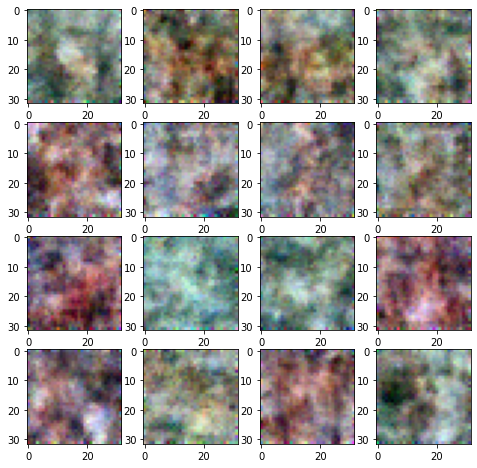

  0%|          | 0/318 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49982509e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49982509e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

  0%|          | 0/318 [00:00<?, ?it/s]

  0%|          | 0/318 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49982509e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49982509e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

  0%|          | 0/318 [00:00<?, ?it/s]

  0%|          | 0/318 [00:00<?, ?it/s]

  0%|          | 0/318 [00:00<?, ?it/s]

  0%|          | 0/318 [00:00<?, ?it/s]

  0%|          | 0/318 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49982509e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49982509e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

  0%|          | 0/318 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49982509e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49982509e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

  0%|          | 0/318 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49982509e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49982509e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

  0%|          | 0/1000 [00:00<?, ?it/s]

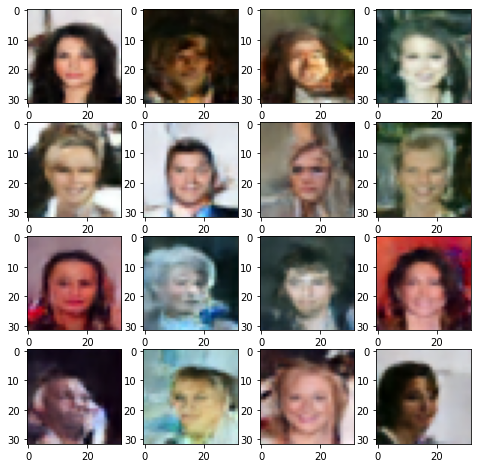

  0%|          | 0/318 [00:00<?, ?it/s]

  0%|          | 0/318 [00:00<?, ?it/s]

  0%|          | 0/318 [00:00<?, ?it/s]

  0%|          | 0/318 [00:00<?, ?it/s]

In [ ]:
logging_dir = os.path.join('.', '/logs')
accelerator = Accelerator(
    mixed_precision=args.mixed_precision,
    log_with="tensorboard",
    logging_dir=logging_dir,
)

model = UNet2DModel(
    sample_size=args.resolution,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 64, 128, 128),
    # block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        # "DownBlock2D",
        # "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        # "UpBlock2D",
        # "UpBlock2D",
    ),
)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, tensor_format="pt")
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=args.learning_rate,
    betas=(args.adam_beta1, args.adam_beta2),
    weight_decay=args.adam_weight_decay,
    eps=args.adam_epsilon,
)

train_dataloader = dataloader

lr_scheduler = get_scheduler(
    args.lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=args.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * args.num_epochs) // args.gradient_accumulation_steps,
)

model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, lr_scheduler
)

ema_model = EMAModel(model, inv_gamma=args.ema_inv_gamma, power=args.ema_power, max_value=args.ema_max_decay)

if args.push_to_hub:
    repo = init_git_repo(args, at_init=True)

if accelerator.is_main_process:
    run = os.path.split('.')[-1].split(".")[0]
    accelerator.init_trackers(run)

global_step = 0
for epoch in range(args.num_epochs):
    model.train()
    progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
    progress_bar.set_description(f"Epoch {epoch}")
    # for step, batch in enumerate(train_dataloader):
    for batch, _ in (train_dataloader):
        # clean_images = batch["input"]
        clean_images = batch #["input"]
        # Sample noise that we'll add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bsz = clean_images.shape[0]
        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bsz,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        with accelerator.accumulate(model):
            # Predict the noise residual
            noise_pred = model(noisy_images, timesteps)["sample"]
            loss = F.mse_loss(noise_pred, noise)
            accelerator.backward(loss)

            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            if args.use_ema:
                ema_model.step(model)
            optimizer.zero_grad()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
        if args.use_ema:
            logs["ema_decay"] = ema_model.decay
        progress_bar.set_postfix(**logs)
        accelerator.log(logs, step=global_step)
        global_step += 1
    progress_bar.close()

    accelerator.wait_for_everyone()

    # Generate sample images for visual inspection
    # if accelerator.is_main_process:
    if epoch % args.save_images_epochs == 0 or epoch == args.num_epochs - 1:
        pipeline = DDPMPipeline(
            unet=accelerator.unwrap_model(ema_model.averaged_model if args.use_ema else model),
            scheduler=noise_scheduler,
        )

        generator = torch.manual_seed(0)
        # run pipeline in inference (sample random noise and denoise)
        images = pipeline(generator=generator, batch_size=args.eval_batch_size, output_type="numpy")["sample"]

        # denormalize the images and save to tensorboard
        images_processed = (images * 255).round().astype("uint8")
        imgs_t = images_processed.transpose(0, 3, 1, 2)
        imgs_plt = images_processed.transpose(0, 1, 2, 3)

        fig = plt.figure(figsize=(8, 8))
        columns = 4
        rows = 4
        for i in range(1, columns*rows +1):
            img = imgs_plt[i-1]
            fig.add_subplot(rows, columns, i)
            plt.imshow(img)
        plt.show()
        accelerator.trackers[0].writer.add_images(
            "test_samples", imgs_t, epoch
        )

    if epoch % args.save_model_epochs == 0 or epoch == args.num_epochs - 1:
        # save the model
        # if args.push_to_hub:
            # push_to_hub(args, pipeline, repo, commit_message=f"Epoch {epoch}", blocking=False)
        # else:
        pipeline.save_pretrained(args.output_dir)
        # pipeline.unet.push_to_hub("celeba_diffusion", use_temp_dir=True)
        # pipeline.scheduler.push_to_hub("celeba_diffusion", use_temp_dir=True)
    accelerator.wait_for_everyone()

accelerator.end_training()

### Train DDPM

In [ ]:
# del ddpm
import torch
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()
# torch.cuda.memory_summary(device=None, abbreviated=False)
!nvidia-smi